# 03 Running a simulation

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import ecm
import liionpack as lp
import pybamm
import numpy as np

In [2]:
pybamm.__version__

'23.9'

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-14 17:59:22,896
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-14 17:59:22,914
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-14 17:59:22,919
------------------------------------------------------------


{'alpha_radial': 0.00012997486546235373, 'alpha_spiral': 0.0018925822276459076, 'lump_rho': 2499.316300105252, 'lump_Cp': 8247.24639489116}


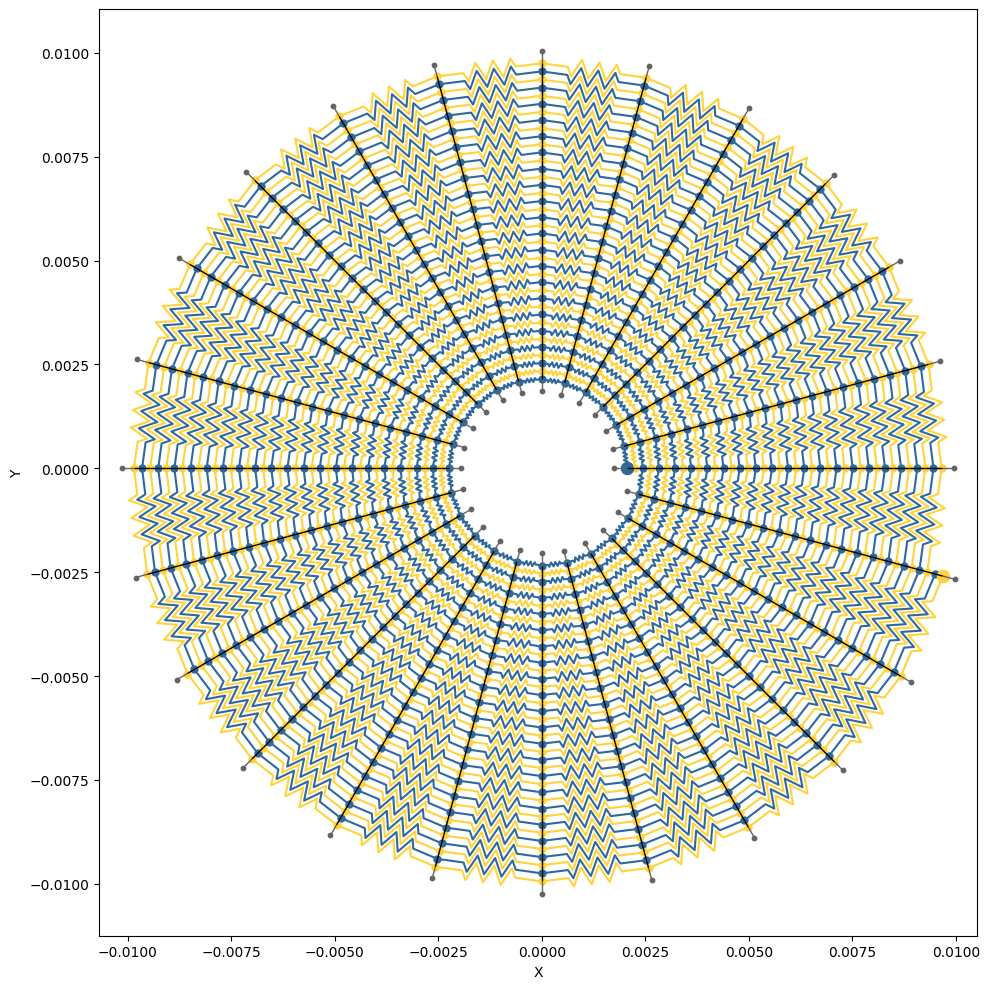

In [3]:
# pybamm.set_logging_level("INFO")
wrk = op.Workspace()
wrk.clear()

# Geometry of spiral
Nlayers = 20
dtheta = 15
spacing = 195e-6  # To do should come from params
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

# Experiment
I_app = 4.0
dt = 5
Nsteps = 360
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        f"Discharge at {I_app} A for {hours} hours",
    ],
    period=f"{dt} seconds",
)

# OpenPNM project
project, arc_edges = ecm.make_spiral_net(Nlayers,
                                         dtheta,
                                         spacing,
                                         inner_r,
                                         pos_tabs,
                                         neg_tabs,
                                         length_3d,
                                         tesla_tabs)
ecm.plot_topology(project.network)
# Parameter set
param = pybamm.ParameterValues("Chen2020")
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param['Electrode width [m]'] = length_3d
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = 0.5
thermal_props = print(ecm.lump_thermal_props(param))



In [4]:
trans_kwargs = {'t_slice':10,'t_precision':1}

# Run simulation
project, output = ecm.run_simulation_lp(parameter_values=param,
                                        experiment=experiment,
                                        initial_soc=None,
                                        project=project,
                                        **trans_kwargs)

/Users/tleo/micromamba/envs/pnm_dev_pinned_intel/lib/python3.10/site-packages/pybamm/models/full_battery_models/base_battery_model.py:910: OptionWarning: The 'lumped' thermal option with 'dimensionality' 0 now uses the parameters 'Cell cooling surface area [m2]', 'Cell volume [m3]' and 'Total heat transfer coefficient [W.m-2.K-1]' to compute the cell cooling term, regardless of the value of the the 'cell geometry' option. Please update your parameters accordingly.
  options = BatteryModelOptions(extra_options)
Initialising simulation:  20%|██        | 1/5 [00:04<00:17,  4.38s/it]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Stepping simulation:  26%|██▋       | 95/361 [01:08<03:15,  1.36it/s]

In [8]:
net = project.network
net.num_pores('free_stream')

36

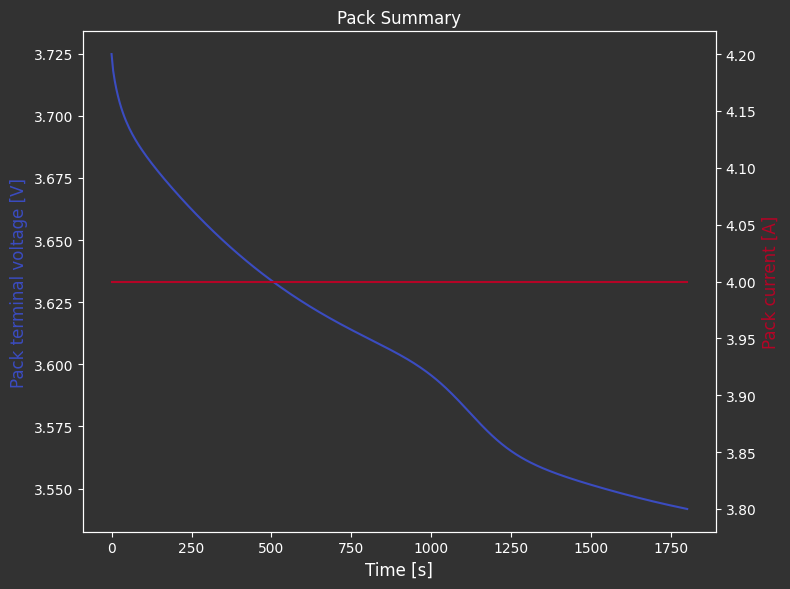

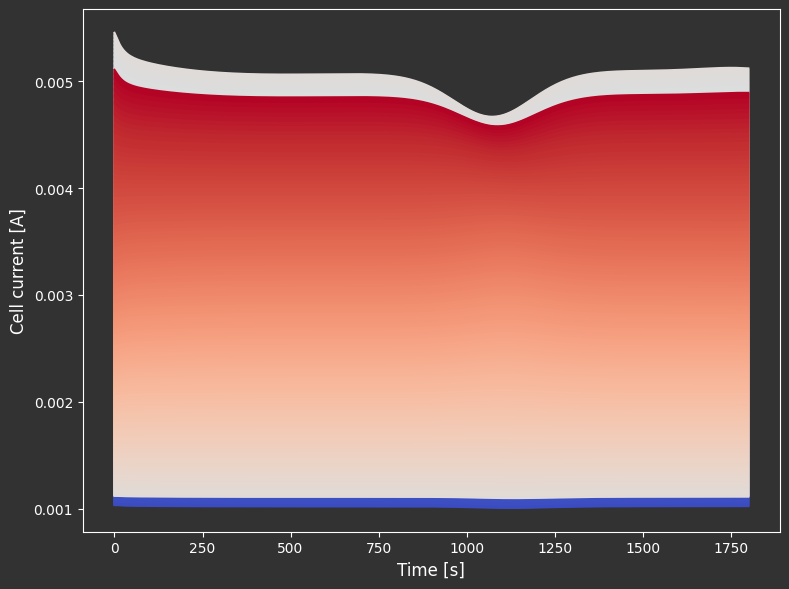

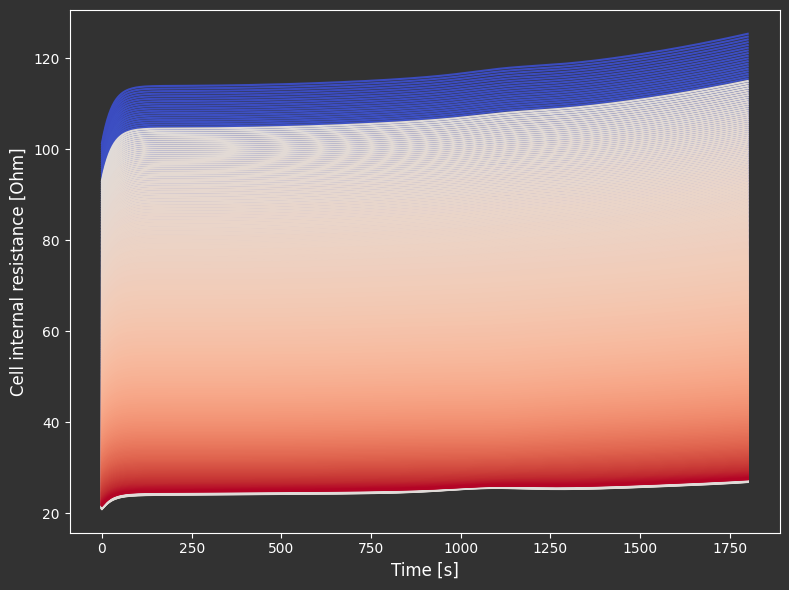

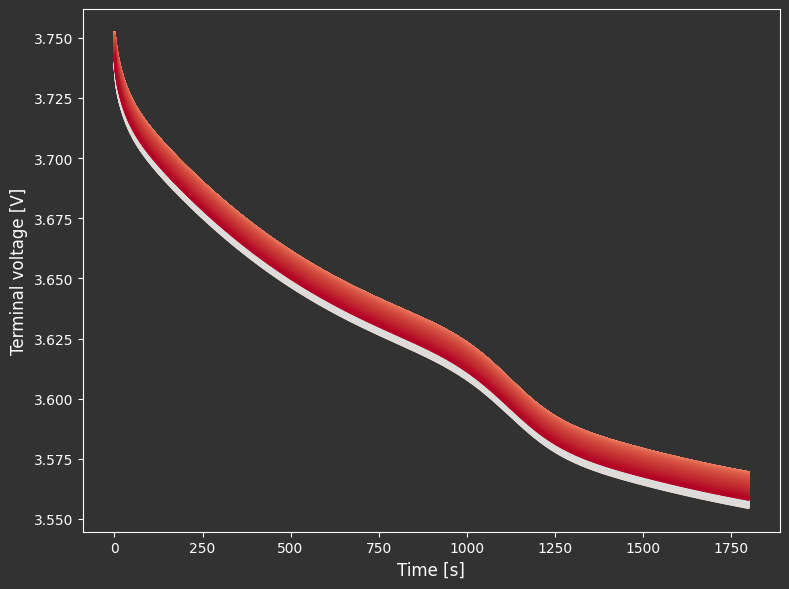

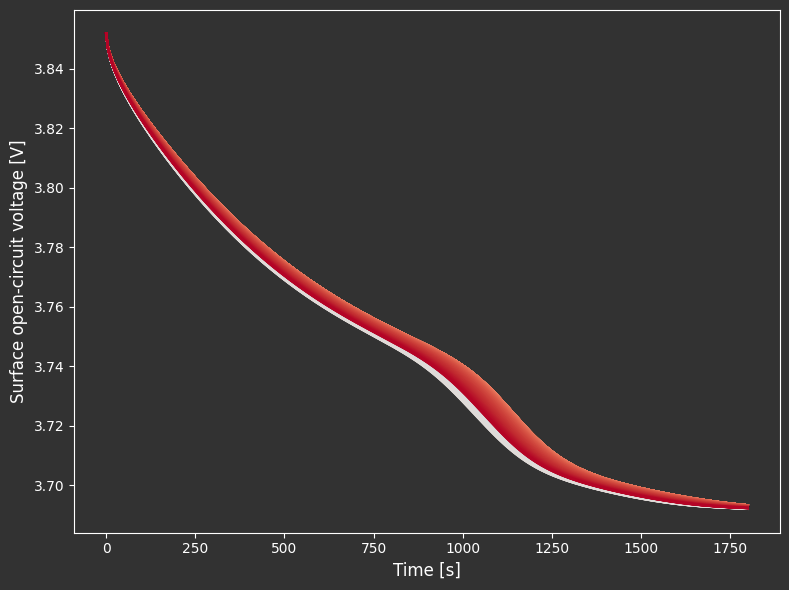

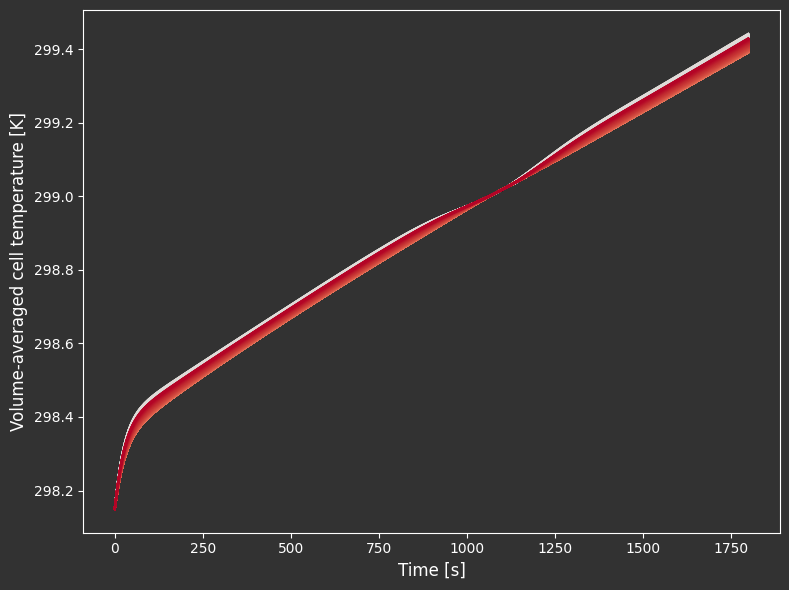

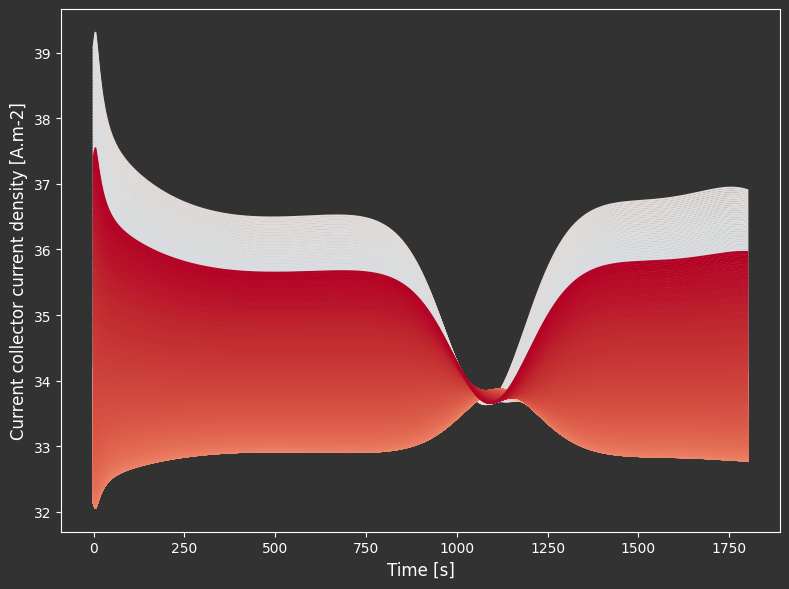

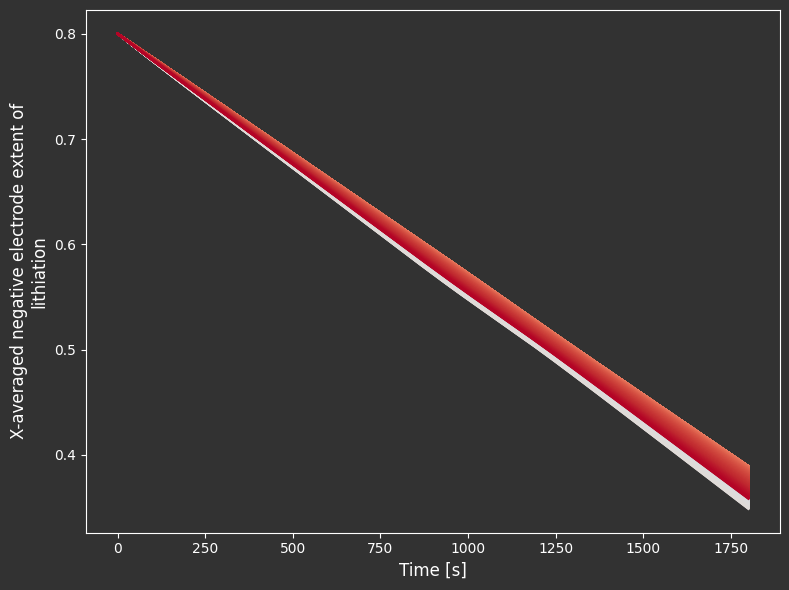

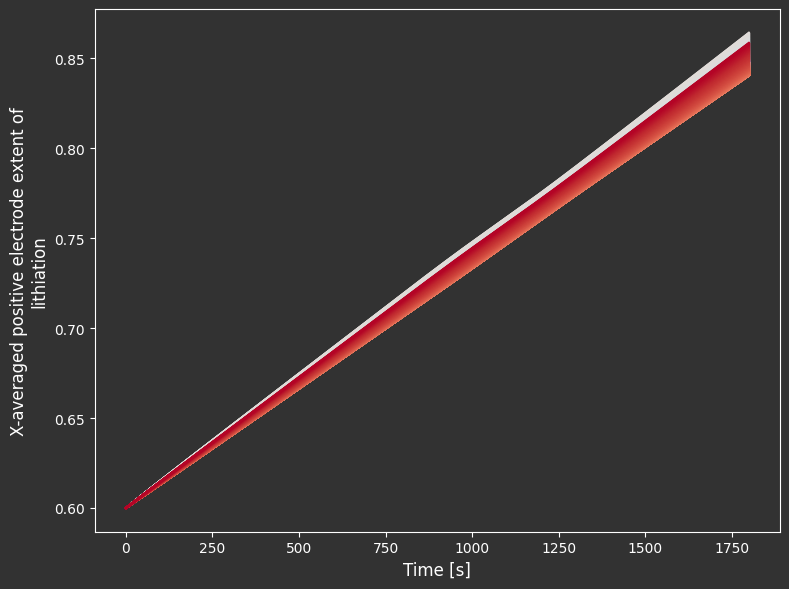

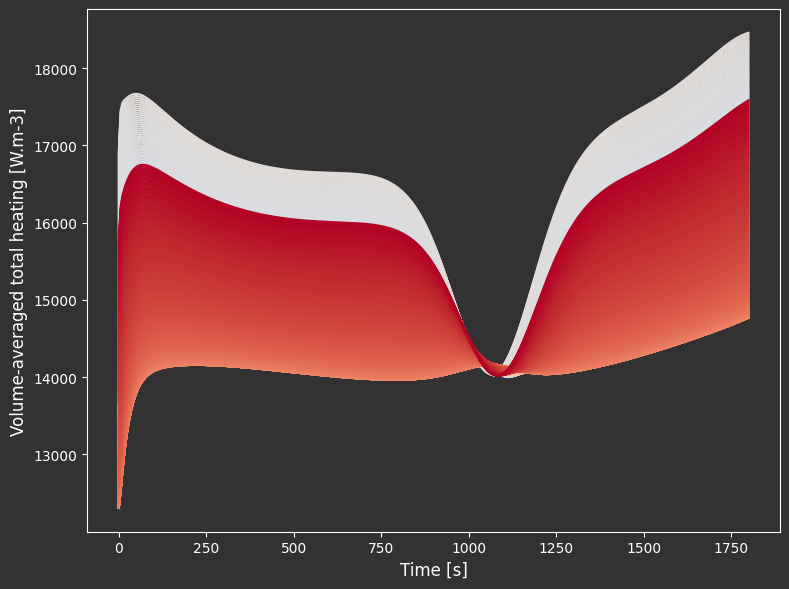

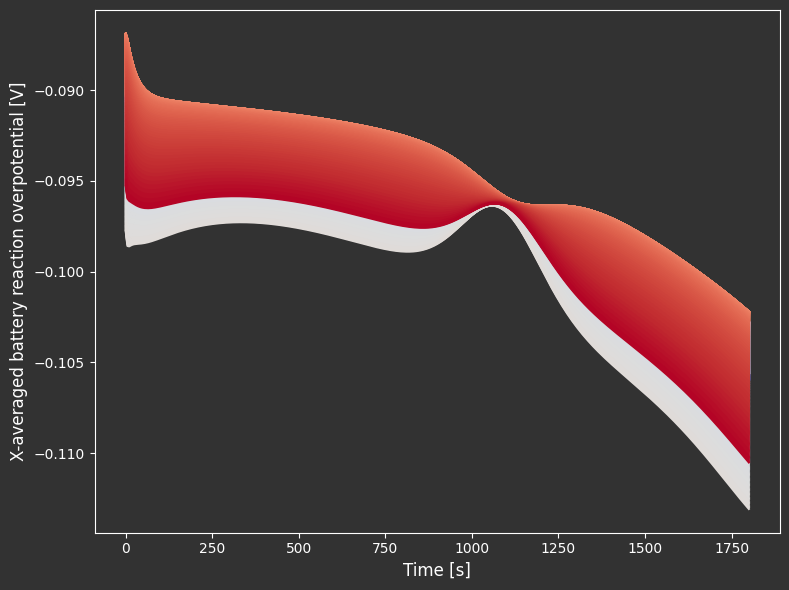

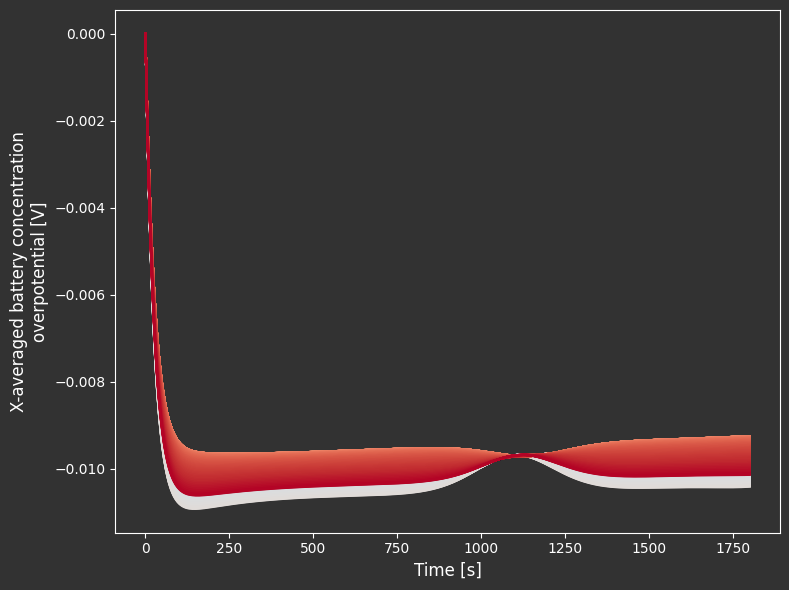

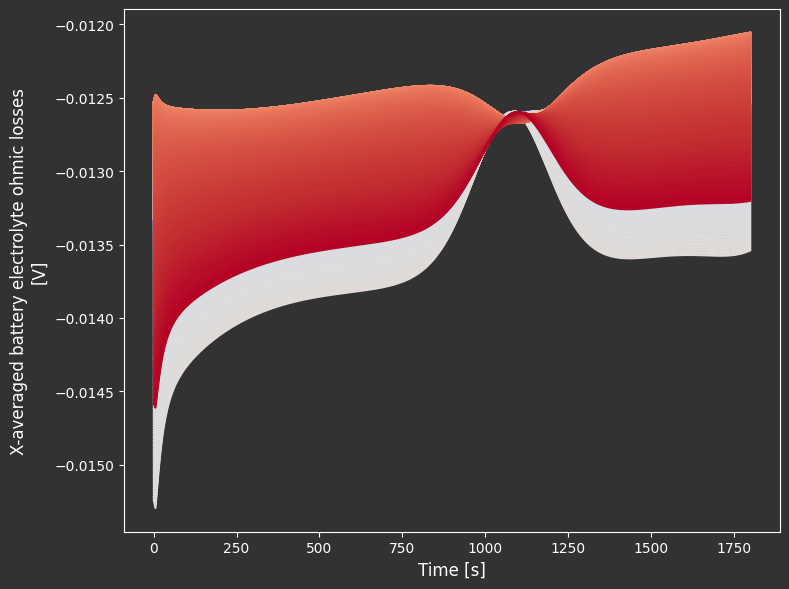

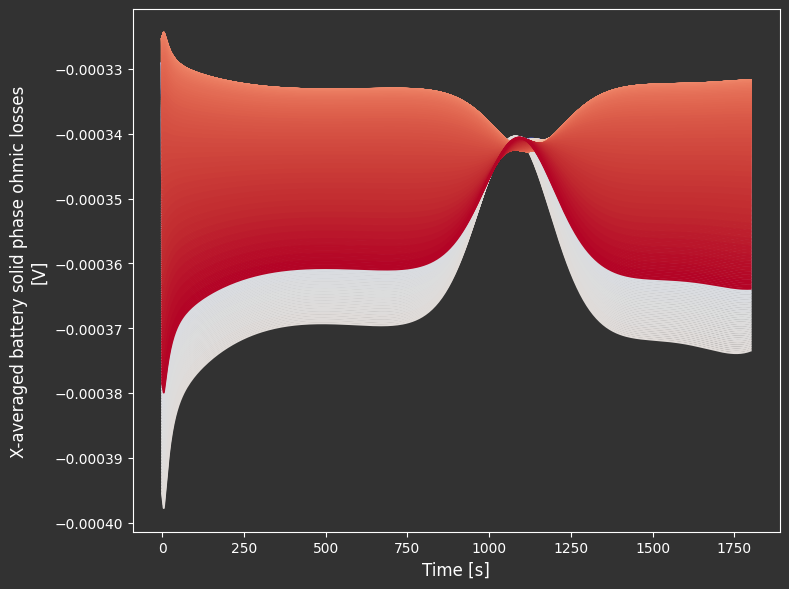

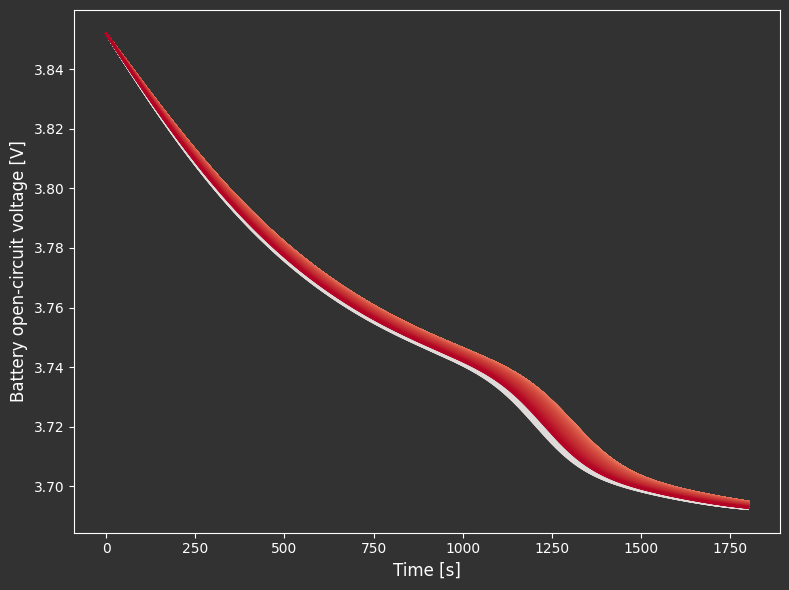

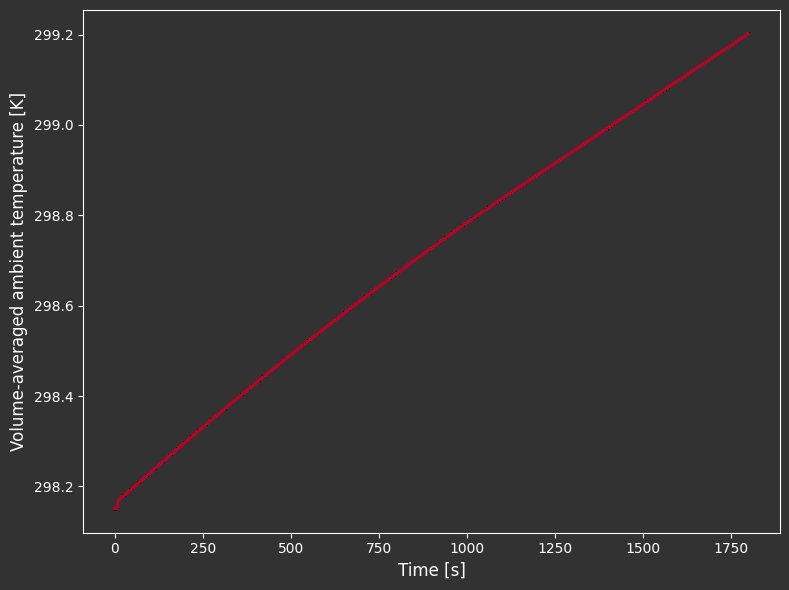

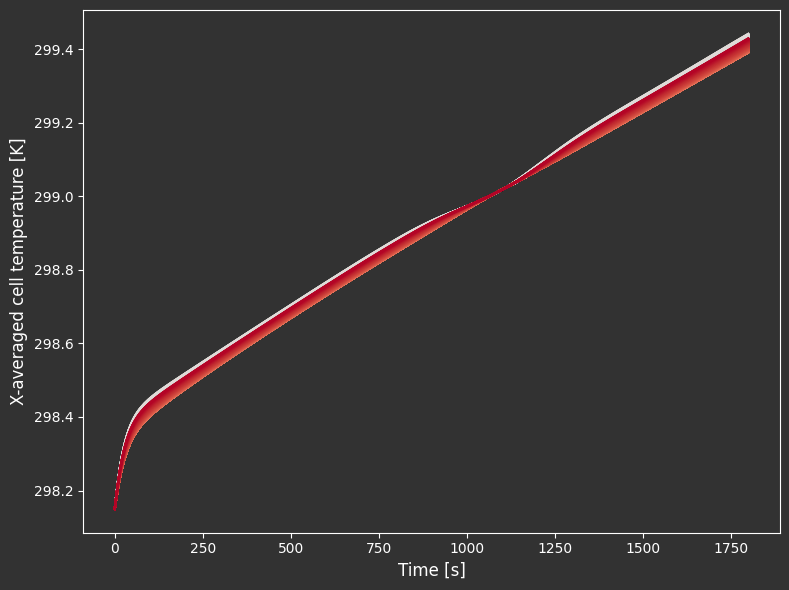

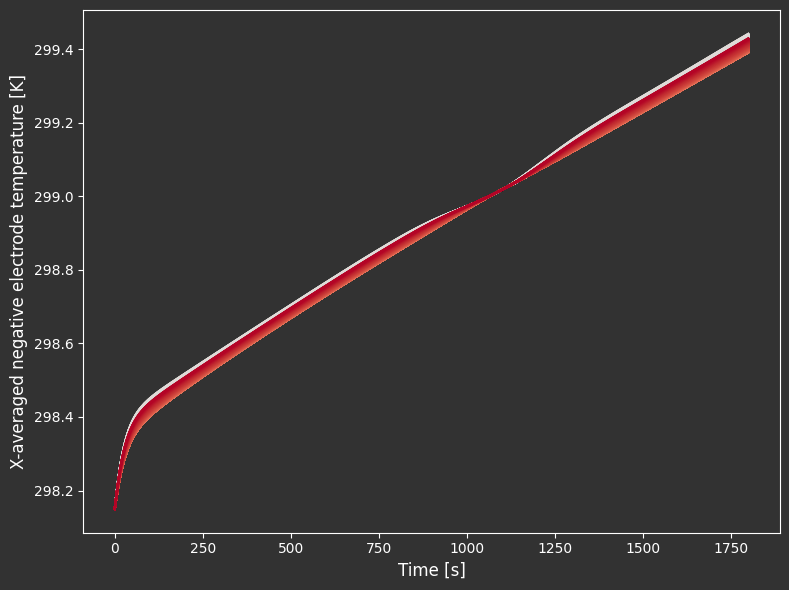

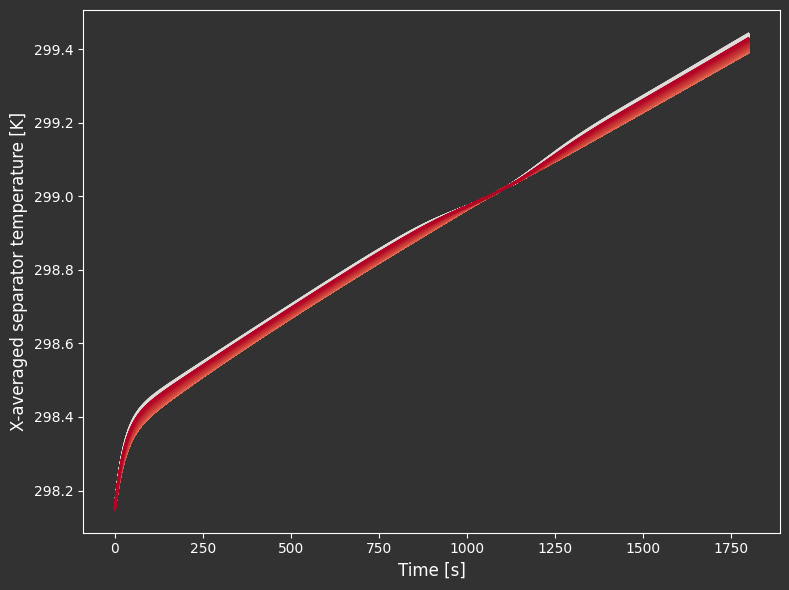

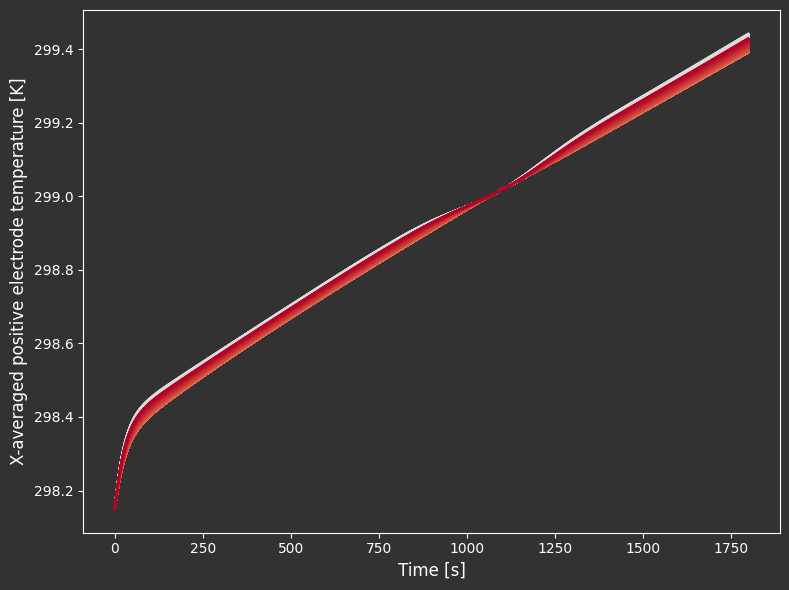

In [9]:
lp.plot_output(output)

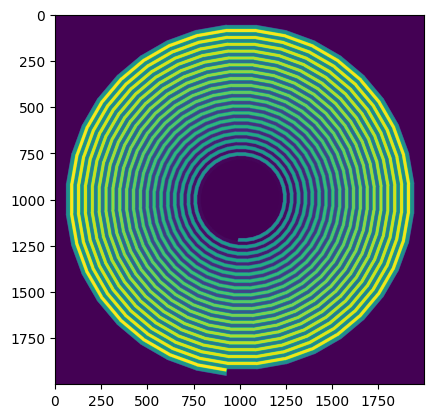

In [10]:
im_spm_map = ecm.interpolate_spm_number(project).astype(int)

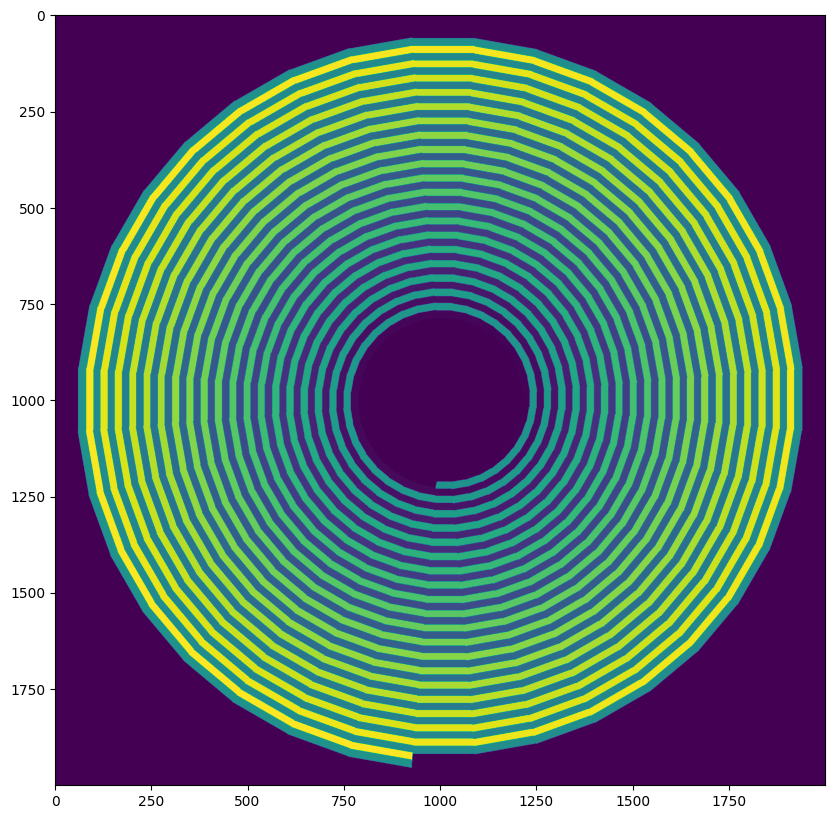

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(im_spm_map)

In [12]:
np.unique(im_spm_map)

array([  -1,    0,    1, ..., 1401, 1402, 1403])

In [13]:
mask = im_spm_map == -1

In [14]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Surface open-circuit voltage [V]', 'Volume-averaged cell temperature [K]', 'Current collector current density [A.m-2]', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation', 'Volume-averaged total heating [W.m-3]', 'X-averaged battery reaction overpotential [V]', 'X-averaged battery concentration overpotential [V]', 'X-averaged battery electrolyte ohmic losses [V]', 'X-averaged battery solid phase ohmic losses [V]', 'Battery open-circuit voltage [V]', 'Volume-averaged ambient temperature [K]', 'X-averaged cell temperature [K]', 'X-averaged negative electrode temperature [K]', 'X-averaged separator temperature [K]', 'X-averaged positive electrode temperature [K]'])

In [15]:
t_data = output['Volume-averaged cell temperature [K]'][-1, :]
i_data = output['Current collector current density [A.m-2]'][-1, :]

In [16]:
arr = np.ones_like(im_spm_map).astype(float)

In [17]:
arr[~mask] = t_data[im_spm_map][~mask]
arr[mask] = np.nan

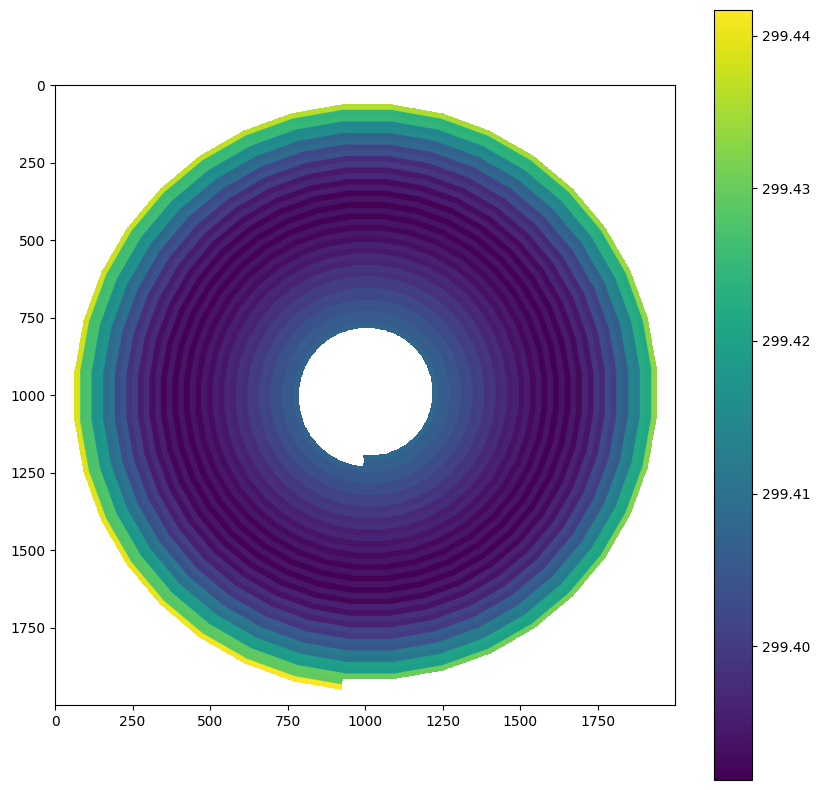

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
im = ax1.imshow(arr)
cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
cbar.ax.locator_params(nbins=6)

In [19]:
t_data.max() - t_data.min()


0.050445557

In [22]:
# create a gif from the images
import imageio
import os

def make_distr_gif(output,im_spm_map,variable='Volume-averaged cell temperature [K]',path='output.gif'):
    mask = im_spm_map == -1
    # the variable that you want to plot should be taken directly from the output
    all_data = output[variable]
    # all_t_data = output['Volume-averaged cell temperature [K]']
    # all_i_data = output['Current collector current density [A.m-2]']

    # the first index is the time index, the second index is the spatial index

    t0_t_data = all_data[0, :]
    n_timesteps = all_data.shape[0]

    # get the min and max temperature over all time points
    min_temp = np.min(all_data)
    max_temp = np.max(all_data)

    # make a matplotlib scalar mappable for colorbar scaling
    norm = plt.Normalize(min_temp, max_temp)


    # loop and pull out the array at each time step
    for i in range(n_timesteps):
        t_data = all_data[i, :]
        # i_data = all_i_data[i, :]
        # create an empty array of the same size as the spatial map
        arr = np.ones_like(im_spm_map).astype(float)
        # use the mask to fill in the array with the data at each time step
        arr[~mask] = t_data[im_spm_map][~mask]
        # set the array at the mask to nan
        arr[mask] = np.nan
        # plot the array and save an image, label the image with the time step
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
        norm = plt.Normalize(min_temp, max_temp)
        im = ax1.imshow(arr,norm=norm,cmap='viridis')
        cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
        cbar.ax.locator_params(nbins=6)
        plt.title(f"Time step {str(i).zfill(3)}")
        plt.savefig(f"output_{str(i).zfill(3)}.png")
        plt.clf()
        plt.close()


    # get the list of files
    files = sorted(os.listdir())
    # filter to only the png files
    files = [f for f in files if f.endswith(".png")]
    # read the images into a list
    images = [imageio.imread(f) for f in files]
    # write the images to a gif
    imageio.mimsave(path, images)
    # delete the images
    for f in files:
        os.remove(f)


make_distr_gif(output,im_spm_map,path='temp_output.gif')
    

In [27]:
# still in dev

import multiprocessing
import mpire
import imageio
import os

def process_time_step(t_data, im_spm_map, mask, min_temp, max_temp, i):
    arr = np.ones_like(im_spm_map).astype(float)
    arr[~mask] = t_data[im_spm_map][~mask]
    arr[mask] = np.nan
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
    norm = plt.Normalize(min_temp, max_temp)
    im = ax1.imshow(arr, norm=norm, cmap='viridis')
    cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
    cbar.ax.locator_params(nbins=6)
    plt.title(f"Time step {str(i).zfill(3)}")
    plt.savefig(f"output_{str(i).zfill(3)}.png")
    plt.clf()
    plt.close()

def make_distr_gif(output, im_spm_map, variable='Volume-averaged cell temperature [K]', path='output.gif'):
    mask = im_spm_map == -1
    all_data = output[variable]
    t0_t_data = all_data[0, :]
    n_timesteps = all_data.shape[0]
    min_temp = np.min(all_data)
    max_temp = np.max(all_data)
    norm = plt.Normalize(min_temp, max_temp)

    pool = mpire.WorkerPool()
    results = []
    stacked_t_data = []
    for i in range(n_timesteps):
        t_data = all_data[i, :]
        stacked_t_data.append(t_data)
    result = pool.imap_unordered(process_time_step, (stacked_t_data, im_spm_map, mask, min_temp, max_temp, i))
    # results.append(result)

    # pool.close()
    pool.join()

    files = sorted(os.listdir())
    files = [f for f in files if f.endswith(".png")]
    images = [imageio.imread(f) for f in files]
    imageio.mimsave(path, images)
    for f in files:
        os.remove(f)

make_distr_gif(output, im_spm_map, path='temp_output_mp.gif')
    

ValueError: need at least one array to stack